In [1]:
# Import necessary libraries
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings("ignore")

# Download stopwords and tokenizer assets
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
# Load and preprocess data
def load_data(file_path):
    data = pd.read_csv(file_path)
    print("Data loaded successfully.")
    return data

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = ' '.join([word for word in word_tokens if word not in stop_words])
    return filtered_text

def preprocess_data(data):
    data['cleaned_text'] = data['text'].apply(preprocess_text)
    print("Data preprocessing completed.")
    return data

# Feature extraction
def extract_features(data, max_features=10000):
    tfidf_vectorizer = TfidfVectorizer(max_features=max_features)
    X = tfidf_vectorizer.fit_transform(data['cleaned_text']).toarray()
    print("Feature extraction completed.")
    return X, tfidf_vectorizer

# Train-test split
def split_data(X, y, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    print("Data split into training and test sets.")
    return X_train, X_test, y_train, y_test

# Train and evaluate models
def evaluate_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'y_pred': y_pred
        }

        print(f"\n{name} Model Evaluation:")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")

    print("\nModel evaluation completed.")
    return results

# Save best model
def save_best_model(results):
    best_model_name = max(results, key=lambda k: results[k]['accuracy'])
    best_model = results[best_model_name]['model']
    joblib.dump(best_model, 'best_spam_classifier.pkl')
    print(f"Best model ({best_model_name}) saved as 'best_spam_classifier.pkl' with accuracy: {results[best_model_name]['accuracy']}")
    return best_model_name, results[best_model_name]

# Confusion matrix visualization
def plot_confusion_matrix(y_test, y_pred, model_name):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Spam (0)', 'Spam (1)'],
                yticklabels=['Not Spam (0)', 'Spam (1)'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Plot performance metrics for all models
def plot_metrics(results):
    metrics_df = pd.DataFrame({
        'Model': list(results.keys()),
        'Accuracy': [results[model]['accuracy'] for model in results],
        'Precision': [results[model]['precision'] for model in results],
        'Recall': [results[model]['recall'] for model in results],
        'F1 Score': [results[model]['f1'] for model in results]
    })

    metrics_df.set_index('Model', inplace=True)
    metrics_df.plot(kind='bar', figsize=(7, 6))
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.xlabel('Model')
    plt.legend(loc='upper right')
    plt.show()

# Main function
def main(file_path):
    # Load and preprocess data
    data = load_data(file_path)
    data = preprocess_data(data)

    # Feature extraction
    X, tfidf_vectorizer = extract_features(data)
    y = data['label']

    # Split data
    X_train, X_test, y_train, y_test = split_data(X, y)

    # Initialize models
    models = {
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(max_iter=1500),
        'Random Forest': RandomForestClassifier(),
    }

    # Evaluate models
    results = evaluate_models(models, X_train, X_test, y_train, y_test)
    return results, y_test


In [3]:
# Run the main function to Train various models and find out the < BEST ONE >
# Displaying evaluation metrics of each model
file_path = 'combined_data.csv'
results, y_test = main(file_path)

Data loaded successfully.
Data preprocessing completed.
Feature extraction completed.
Data split into training and test sets.

Naive Bayes Model Evaluation:
Accuracy: 0.9695626123427202
Precision: 0.9697649781325556
Recall: 0.9695626123427202
F1 Score: 0.9695760603018673

Logistic Regression Model Evaluation:
Accuracy: 0.9839025364489714
Precision: 0.983958966107725
Recall: 0.9839025364489714
F1 Score: 0.9838966771125893

Random Forest Model Evaluation:
Accuracy: 0.9844218094667465
Precision: 0.9844215025171518
Recall: 0.9844218094667465
F1 Score: 0.9844215992731828

Model evaluation completed.


In [4]:
# Save and display best model
best_model_name, best_model_results = save_best_model(results)

Best model (Random Forest) saved as 'best_spam_classifier.pkl' with accuracy: 0.9844218094667465


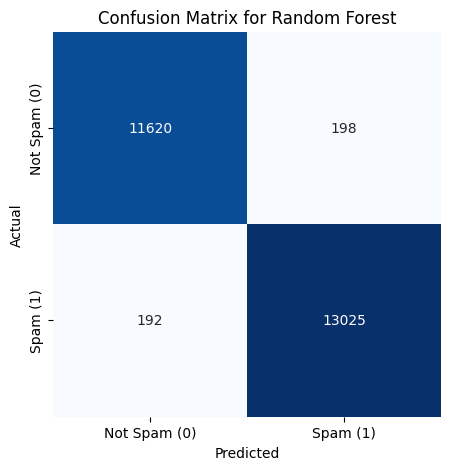

In [5]:
# Best Model - Confusion Matrix
plot_confusion_matrix(y_test, best_model_results['y_pred'], best_model_name)


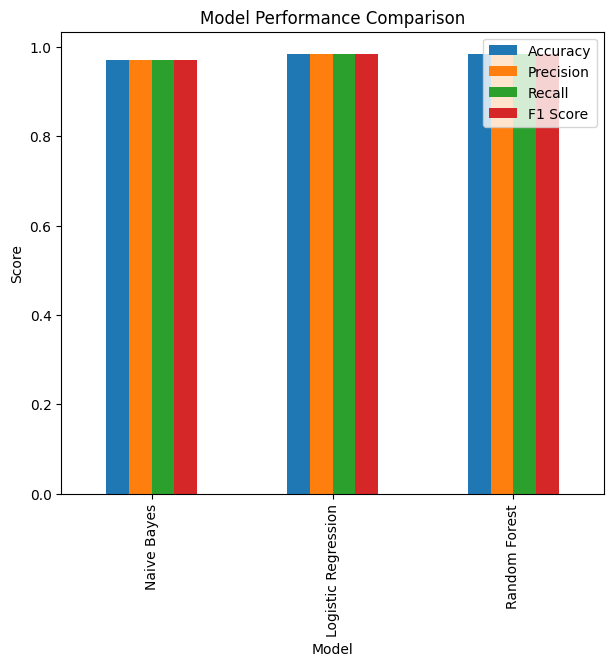

In [6]:
# Plot metrics for all models
plot_metrics(results)